**Image-to-image translation** : 주어진 이미지의 특정 측면을 다른 면으로 변경 (찡그린 얼굴 -> 웃는 얼굴)

![image](https://user-images.githubusercontent.com/44194558/138996325-b3706f83-cb8d-4e2f-82ae-eed6a76e5027.png)

<br/>

**Cycle GAN**

cGAN 이후 paired data를 기반으로 하는 pix2pix에서 발전이 있었음. 이후 제안된 CycleGAN은 paired data를 필요로 하지 않으면서 이미지의 도메인 pair 각각에 대해 서로 다른 네트워크를 구축한다. (이미지를 7개의 도메인으로 translate한다면 7개의 서로 다른 생성자와 판별자가 필요함)

도메인이 많을 수록 각 도메인 쌍에 대해 서로 다른 모델을 훈련해야 한다는 한계가 있음. (Learning the relation btw 2 different domains)

<br/>

**StarGAN** : Multi domain image-to-image translation

다중 도메인을 연결하는 star topology에서 아이디어를 얻어, 단일 생성자를 사용하여 여러 도메인 간의 mapping을 실습함. 하나의 네트워크만 사용하여 서로 다른 속성을 가진 여러 데이터셋에서 학습이 가능함. (Learning the relation btw multi domains)

Single generator만으로 학습이 가능하고, 동시에 여러 도메인 간의 mapping을 학습할 수 있어, 다중 도메인 전환이 가능함. (Only a single model should be trained for multiple domains)

판별자는 진짜 이미지를 그것에 상응하는 도메인으로 분류. 여러 도메인을 제어하기 위한 보조 분류기의 역할을 수행하며, 입력으로 들어온 이미지와 도메인 분류 결과에 대한 진짜 여부를 판별.

생성자는 가짜 이미지를 생성하고, 가짜 이미지로부터 원본 이미지를 재구성.

<br/>



![image](https://user-images.githubusercontent.com/44194558/138996971-416bb598-9841-4d80-a4ef-bcf918a71c2e.png)

To reach this, we need to train G to translate an input image x to an output image y conditioned on the target domain label c, G(x, c) → y. We randomly generate the target domain label c. An auxiliary classifier was introduced that allows a single discriminator to control multiple domains.



## Kaggle에서 데이터 불러오기

출처 : https://www.kaggle.com/jessicali9530/celeba-dataset

이전 실습들과 다른 데이터 사용

1. Kaggle 계정에 로그인
2. Account -> Create NEW API Token 선택 (kaggle.json이 자동으로 다운로드됨)

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 7.7 MB/s 


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()   # 다운받은 kaggle.json 업로드 

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/  # kaggle 디렉토리 생성 & 해당 디렉토리에 kaggle.json 복사
! chmod 600 ~/.kaggle/kaggle.json  # 권한 변경

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              235KB  2021-10-21 20:52:33          14537  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           8707  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           3886  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3239  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

In [ ]:
! kaggle datasets download -d jessicali9530/celeba-dataset  # 필요한 데이터 다운로드

100% 1.32G/1.33G [00:09<00:00, 136MB/s]
100% 1.33G/1.33G [00:09<00:00, 145MB/s]


In [ ]:
! mkdir train # train 디렉토리 생성
! unzip celeba-dataset.zip -d train # unzip 

In [ ]:
%load_ext tensorboard

import csv
import os
import glob
import time
import random

import functools
import numpy as np
import tqdm

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras
import tensorflow_addons as tfa
%matplotlib inline

## Configs

In [ ]:
# Experiment paths
EXPERIMENT_ID = "train"
MODEL_SAVE_PATH = os.path.join("/content/drive/My Drive/StarGAN", EXPERIMENT_ID)
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)
CHECKPOINT_NAME = "checkpoint"
CHECKPOINT_PATH = os.path.join(MODEL_SAVE_PATH, CHECKPOINT_NAME)

# Data
DATA_PATH = '/content/train/img_align_celeba/img_align_celeba/*'
ATTRIBUTE_PATH = '/content/train/list_attr_celeba.csv'
ATTRIBUTES = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Mustache', 'Young']  # 사용할 5개의 도메인

# Model parameters
EPOCHS = 100
N_CRITIC = 5
BATCH_SIZE = 64 
IMG_SHAPE = (128, 128, 3)
NUM_CLASS = 5
AUTOTUNE = tf.data.experimental.AUTOTUNE
LR = 0.0001 
BETA = 0.5

seed = random.seed(30)

## Data Exploration

In [ ]:
def get_images_paths(path):
    img_paths = []
    for filename in glob.glob(path):
        img_paths.append(filename)
    return list(img_paths)

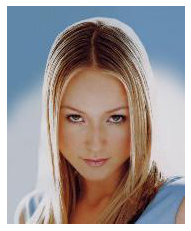

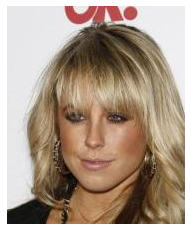

In [ ]:
img_paths = get_images_paths(DATA_PATH)
for image_path in img_paths[:2]:
    image = mpimg.imread(str(image_path))
    plt.figure()
    plt.axis('off')
    plt.imshow(image)

In [ ]:
image_size = []
for filename in img_paths:
    im=Image.open(filename)
    im =im.size
    image_size.append(im)
print(max(image_size))
print(min(image_size))

(178, 218)
(178, 218)


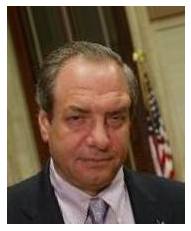

In [ ]:
image = mpimg.imread(img_paths[30])

plt.axis("off")
plt.imshow(image)

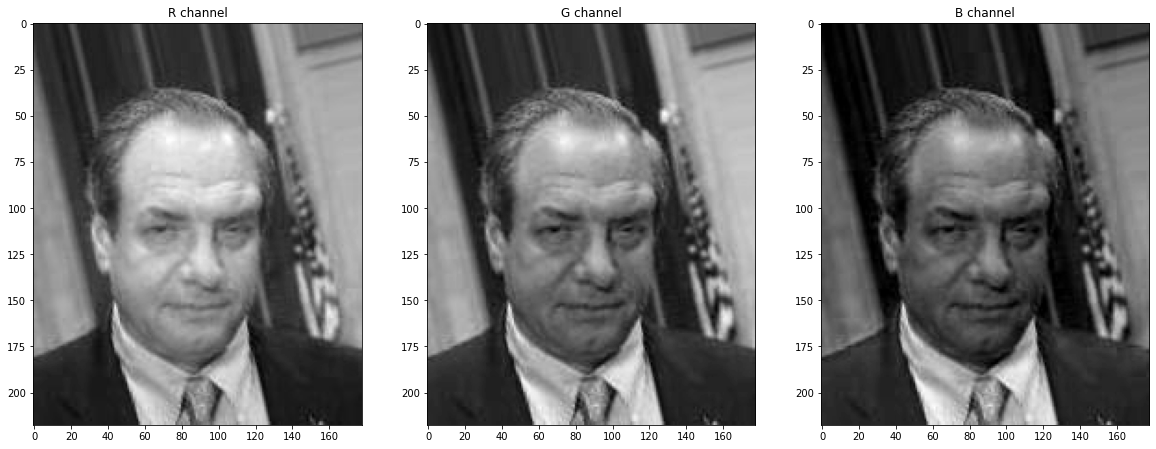

In [ ]:
r = image[:,:,0]
g = image[:,:,1]
b = image[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ax1.set_title('R channel')
ax1.imshow(r, cmap='gray')
ax2.set_title('G channel')
ax2.imshow(g, cmap='gray')
ax3.set_title('B channel')
ax3.imshow(b, cmap='gray')

각 이미지는 40개의 특성들을 가짐. 해당 특성을 보유하고 있으면 1, 아니면 -1

In [ ]:
# Attributes
attribute_file = open(ATTRIBUTE_PATH, "r")
for x in attribute_file:
    print(x)

## Data Pipeline

도메인 정보를 표현하기 위해 label 이진 벡터를 사용

다음 5개의 도메인 사용  ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Mustache', 'Young'] 

In [ ]:
attr_info_array = []

In [ ]:
ATTRIBUTES

['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Mustache', 'Young']

In [ ]:
with open(ATTRIBUTE_PATH, 'r') as f:
    reader = csv.reader(f)
    for row in reader: # 개별 행은 리스트
        attr_info_array.append(row)
        
attr2idx = {}
idx2attr = {}
for i, attr in enumerate(attr_info_array[0]):
    if attr in ATTRIBUTES:
        attr2idx[attr] = i
        idx2attr[i] = attr

In [ ]:
attr2idx

{'Black_Hair': 9,
 'Blond_Hair': 10,
 'Brown_Hair': 12,
 'Mustache': 23,
 'Young': 40}

In [ ]:
image_label = [[0. for _ in range(len(ATTRIBUTES))] for _ in range(len(attr_info_array[1:]))] 
for i, attr in enumerate(attr_info_array[1:]):
    cols = attr[:]
    for j, attr in enumerate(ATTRIBUTES):
        if cols[attr2idx[attr]] == '1':
            image_label[i][j] = 1.

In [ ]:
image_label[0:5]

[[0.0, 0.0, 1.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0]]

## Data Loader

In [ ]:
@tf.function
def preprocessing_data(path, image_label, target_label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, dtype=tf.float32)
    image = (image / 127.5) - 1
    return image, image_label, target_label


def dataloader():
    # 이미지
    images = tf.data.Dataset.from_tensor_slices(img_paths)

    # 도메인 label
    ori_label_ds = tf.data.Dataset.from_tensor_slices(image_label)  # 이미지의 실제 label
    tar_label_ds = tf.data.Dataset.from_tensor_slices(image_label).shuffle(10*BATCH_SIZE)  # 이미지의 타깃 label (랜덤하게 섞음)

    dataset = tf.data.Dataset.zip((images, ori_label_ds, tar_label_ds))
    dataset = dataset.map(lambda x, y, z: preprocessing_data(x, y, z), num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

In [ ]:
train_dataset = dataloader()

In [ ]:
for images, ori_labels, tar_labels in train_dataset.take(1):
    for img, o_label, t_label in zip(images, ori_labels, tar_labels):
        img_np = img.numpy()
        plt.figure()
        plt.title("original label  " + str(o_label)+ "target label  " + str(t_label))
        plt.imshow((img_np-img_np.min())/(img_np.max()-img_np.min()))
        # ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Mustache', 'Young']

# 두 번째 여자 이미지 : 갈색 머리 + 젊음 (원본 도메인) -> 젊음을 유지하되 머리 색 도메인은 갈색에서 검은색으로 변경

![image](https://user-images.githubusercontent.com/44194558/139205926-995cfb0a-d757-4304-a64d-94feb4423522.png)

## Modeling

![image](https://user-images.githubusercontent.com/44194558/139002566-eab807f7-8c29-4b05-861f-10b7c3cfdcb6.png)

<br/>

**생성자** 

- 처음부터 생성하는 것이 아니기 때문에 노이즈 필요 x. 데이터셋에서 이미지를 가져와 스타일을 이해

- 이미지와 타깃 도메인 레이블을 입력받아 가짜 이미지 생성. (진짜와 구별이 불가능하고, 타깃 도메인으로 분류가 가능하도록)

- 생성된 가짜 이미지와 원래의 도메인 레이블을 입력받아 원본 이미지를 재구성(reconstruct)

 <br/>

**판별자**

- 실제, 가짜 이미지를 판별하고, 실제 이미지를 실제 도메인으로 분류하는 방법을 학습


 

모델링 코드 참고 : 

https://paperswithcode.com/paper/stargan-unified-generative-adversarial

https://github.com/taki0112/StarGAN-Tensorflow/blob/master/StarGAN.py

https://oranz.tistory.com/48

### Generator

In [ ]:
# Residual Block
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, dim, norm_layer, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, norm_layer, use_bias=False)

    def build_conv_block(self, dim, norm_layer, use_bias):
        conv_block = []
        p = 'same'

        conv_block += [tf.keras.layers.Conv2D(dim, (3, 3), padding=p, use_bias=use_bias), 
                       norm_layer(),
                       tf.keras.layers.Activation('relu')]

        conv_block += [tf.keras.layers.Conv2D(dim, (3, 3), padding=p, use_bias=use_bias),
                       norm_layer()]

        return tf.keras.Sequential(conv_block)

    def call(self, x, training=True):
        out = x + self.conv_block(x, training=training)  # input과 output을 더해줌 (Skip Connection)
        return out

In [ ]:
class Generator(tf.keras.layers.Layer):
    def __init__(self, 
                 channels=3,
                 ngf=64,
                 norm_layer=tfa.layers.normalizations.InstanceNormalization,
                 use_bias=False,
                 n_blocks=6):
      
        super(Generator, self).__init__()

        self.concat = tf.keras.layers.Concatenate()  # 입력 이미지와 도메인을 연결

        assert(n_blocks >= 0)

        # Encoder with Down-sampling (총 4개의 블록으로 구성)
        # 모든 ConvLayer는 더욱 높은 차원의 동적 특징을 추출
        model = [tf.keras.layers.Conv2D(ngf, (7, 7), padding='same', use_bias=use_bias),
                 norm_layer(),
                 tf.keras.layers.Activation('relu')]
        
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [tf.keras.layers.Conv2D(ngf * mult * 2, (3, 3), strides=(2, 2), padding='same'),
                      norm_layer(),
                      tf.keras.layers.Activation('relu')]

        # Bottleneck layers
        # 더 중요한 항목을 추출한 후, 이미지의 다른 인접한 항목을 결합 -> 변환 결정
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, norm_layer=norm_layer)]  
        
        # Decoder with Up-sampling (Transepose Block)
        # 고유한 정보를 추출하고 해당 항목의 표현이 변환된 이미지로 바뀜
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [tf.keras.layers.Conv2DTranspose(int(ngf * mult / 2),  # encoding의 역
                                                      (3, 3), strides=(2, 2),
                                                      padding='same'),
                      norm_layer(),
                      tf.keras.layers.Activation('relu')]

        model += [tf.keras.layers.Conv2D(channels, (7, 7), padding='same'),
                  tf.keras.layers.Activation('tanh')]

        self.model = tf.keras.Sequential(model)

    def call(self, inputs, domains, training=True):
        domains = tf.reshape(domains, (-1, 1, 1, domains.shape[1]))
        domains = tf.tile(domains, tf.constant([1, inputs.shape[1], inputs.shape[2], 1]))
        x = self.concat([inputs, domains])  # 입력, 도메인을 연결
        return self.model(x, training=training)

대칭적인 조건으로 (입력과 동일한 사이즈의 출력)) Down-sampling, Up-sampling이 이루어지는 중간에 ResidualBlock이 Bottleneck layer로 사용. 

call에서 도메인 레이블이 이미지 사이즈에 맞춰 확대되고 concatenate되는 방식으로 학습이 진행됨.

### Discriminator

ACGAN의 판별자와 유사한 기능

![image](https://user-images.githubusercontent.com/44194558/139023773-7d6ff2e5-dc83-4235-ac3e-7deb9b3013cd.png)

In [ ]:
class Discriminator(tf.keras.layers.Layer):
    def __init__(self, img_shape, nd, ndf=64, n_layers=5, use_bias=False):
        super(Discriminator, self).__init__()

        h, w = img_shape[0:2]
        
        # 이미지에서 중요한 항목을 추출하여 최종 결정을 돕는 Convolutional Layer
        kw = 4
        model = [tf.keras.layers.Conv2D(ndf, (kw, kw), strides=(2, 2), padding='same'),  
                 tf.keras.layers.LeakyReLU(0.01)]

        nf_mult = 1
        for n in range(1, n_layers + 1):
            nf_mult = 2 ** n
            model += [tf.keras.layers.Conv2D(ndf * nf_mult, (kw, kw), strides=(2, 2), padding='same'),
                      tf.keras.layers.LeakyReLU(0.01)]

        self.model = tf.keras.Sequential(model)
        
        # 이진 분류 (진짜/가짜)
        self.src = tf.keras.layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=use_bias)  

        # 레이블 분류 
        self.cls = tf.keras.layers.Conv2D(nd, (h // 64, w // 64), strides=(1, 1), padding='valid', use_bias=use_bias)

    def call(self, inputs, training=True):
        x = self.model(inputs, training=training)
        return self.src(x), tf.squeeze(self.cls(x))  # 크기 1의 차원을 제거하여 최종 출력으로

In [ ]:
generator = Generator()

In [ ]:
discriminator = Discriminator(IMG_SHAPE, NUM_CLASS)

## Training Process

In [ ]:
gen_optimizer = tf.keras.optimizers.Adam(LR, BETA)
disc_optimizer = tf.keras.optimizers.Adam(LR, BETA)

# loss
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # 분류
l1 = tf.keras.losses.MeanAbsoluteError()  # Reconstruction loss

In [ ]:
def gradient_penalty_loss(averaged_output, x_hat):
    gradients = tf.gradients(averaged_output, x_hat)[0]
    gradients_sqr = tf.square(gradients)
    gradients_sqr_sum = tf.reduce_sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    gradients_l2_norm = tf.sqrt(gradients_sqr_sum)

    gradient_penalty = tf.square(gradients_l2_norm - 1)

    return tf.reduce_mean(gradient_penalty)

def random_weighted_average(inputs):
    alpha = tf.random.uniform((inputs[0].shape[0], 1, 1, 1))
    return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

def discriminator_loss(real_output, fake_output, averaged_output, interpolated_img, lamb_gp=10):
    real_loss = -tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    gp_loss = gradient_penalty_loss(averaged_output, interpolated_img)
    total_loss = real_loss + fake_loss + gp_loss* lamb_gp
    return total_loss

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def reconstrution_loss(loss_object, real_image, recon_image, lamb_rec=10):
    return loss_object(real_image, recon_image) * lamb_rec 

def domain_classification_loss(loss_object, category, output, lamb_cls=1):
    return loss_object(category, output) * lamb_cls

In [ ]:
@tf.function
def train_generator(images, ori_labels, tar_labels):
    with tf.GradientTape(persistent=True) as tape:
        fake_images = generator(images, tar_labels)  # 타깃 레이블이 붙은 이미지를 획득하여 가짜 이미지를 생성
        recon_images = generator(fake_images, ori_labels)  # 원본 레이블이 붙은 가짜 이미지로부터 원본 이미지의 재구성을 시도

        fake_output, fake_class = discriminator(fake_images)
        
        # loss
        gen_loss = generator_loss(fake_output)
        fake_class_loss = domain_classification_loss(bce, tar_labels, fake_class)
        recon_loss = reconstrution_loss(l1, images, recon_images) 

        total_gen_loss = gen_loss + fake_class_loss + recon_loss 

    grad_gen = tape.gradient(total_gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))

    return fake_images, {'gen_loss' : gen_loss,
                         'fake_class_loss' : fake_class_loss,
                         'recon_loss' : recon_loss}

In [ ]:
@tf.function
def train_discriminator(images, ori_labels, tar_labels):
    with tf.GradientTape(persistent=True) as tape:
        # real
        real_output, real_class = discriminator(images)

        # fake
        fake_images = generator(images, tar_labels)  # 타깃 레이블로 생성된 가짜 이미지 구별
        fake_output, fake_class = discriminator(fake_images)

        # x_hat
        interpolated_img = random_weighted_average([images, fake_images])  # 보간 이미지 생성
        averaged_output, _ = discriminator(interpolated_img)

        disc_loss = discriminator_loss(real_output, fake_output, averaged_output, interpolated_img)  # wgan gp loss

        real_class_loss = domain_classification_loss(bce, ori_labels, real_class)

        total_disc_loss = disc_loss + real_class_loss

    grad_disc = tape.gradient(total_disc_loss, discriminator.trainable_variables)

    disc_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

    return {'real_class_loss' : real_class_loss,
            'disc_loss' : disc_loss}

In [ ]:
class Checkpoint:
    """Enhanced "tf.train.Checkpoint"."""

    def __init__(self,
                 checkpoint_kwargs,  # for "tf.train.Checkpoint"
                 directory,  # for "tf.train.CheckpointManager"
                 max_to_keep=5,
                 keep_checkpoint_every_n_hours=None):
        self.checkpoint = tf.train.Checkpoint(**checkpoint_kwargs)
        self.manager = tf.train.CheckpointManager(self.checkpoint, directory, max_to_keep, keep_checkpoint_every_n_hours)

    def restore(self, save_path=None):
        save_path = self.manager.latest_checkpoint if save_path is None else save_path
        return self.checkpoint.restore(save_path)

    def save(self, file_prefix_or_checkpoint_number=None, session=None):
        if isinstance(file_prefix_or_checkpoint_number, str):
            return self.checkpoint.save(file_prefix_or_checkpoint_number, session=session)
        else:
            return self.manager.save(checkpoint_number=file_prefix_or_checkpoint_number)

    def __getattr__(self, attr):
        if hasattr(self.checkpoint, attr):
            return getattr(self.checkpoint, attr)
        elif hasattr(self.manager, attr):
            return getattr(self.manager, attr)
        else:
            self.__getattribute__(attr)  # this will raise an exception

In [ ]:
def summary(name_data_dict,
            step=None,
            types=['mean', 'std', 'max', 'min', 'sparsity', 'histogram'],
            historgram_buckets=None,
            name='summary'):
    """Summary.
    Examples
    --------
    >>> summary({'a': data_a, 'b': data_b})
    """
    def _summary(name, data):
        if data.shape == ():
            tf.summary.scalar(name, data, step=step)
        else:
            if 'mean' in types:
                tf.summary.scalar(name + '-mean', tf.math.reduce_mean(data), step=step)
            if 'std' in types:
                tf.summary.scalar(name + '-std', tf.math.reduce_std(data), step=step)
            if 'max' in types:
                tf.summary.scalar(name + '-max', tf.math.reduce_max(data), step=step)
            if 'min' in types:
                tf.summary.scalar(name + '-min', tf.math.reduce_min(data), step=step)
            if 'sparsity' in types:
                tf.summary.scalar(name + '-sparsity', tf.math.zero_fraction(data), step=step)
            if 'histogram' in types:
                tf.summary.histogram(name, data, step=step, buckets=historgram_buckets)

    with tf.name_scope(name):
        for name, data in name_data_dict.items():
            _summary(name, data)

In [ ]:
train_summary_writer = tf.summary.create_file_writer(os.path.join(MODEL_SAVE_PATH, 'summaries', 'train'))
ep_cnt = tf.Variable(initial_value=0, trainable=False, dtype=tf.int64)
checkpoint = Checkpoint(dict(generator=generator,
                                discriminator=discriminator,
                                gen_optimizer=gen_optimizer,
                                disc_optimizer=disc_optimizer,
                                ep_cnt=ep_cnt),
                                CHECKPOINT_PATH,
                                max_to_keep=5)

In [ ]:
len_dataset = len(img_paths) // BATCH_SIZE

In [ ]:
with train_summary_writer.as_default():
    for ep in tqdm.trange(EPOCHS, desc='Epoch Loop'):
        if ep < ep_cnt:
            continue

        # update epoch counter
        ep_cnt.assign_add(1)

        # train for an epoch
        for images, ori_labels, tar_labels in tqdm.tqdm(train_dataset, desc='Inner Epoch Loop', total=len_dataset):
            D_loss_dict = train_discriminator(images, ori_labels, tar_labels)
            summary(D_loss_dict, step=disc_optimizer.iterations, name='D_losses')
            if disc_optimizer.iterations.numpy() % N_CRITIC == 0:
                fake_images, G_loss_dict = train_generator(images, ori_labels, tar_labels)
                # # summary
                summary(G_loss_dict, step=gen_optimizer.iterations, name='G_losses')
            # sample
            if gen_optimizer.iterations.numpy() % 2000 == 0:
                fake_images, G_loss_dict = train_generator(images, ori_labels, tar_labels)
                for idx, (orig_img, fake_img) in enumerate(zip(images, fake_images)):
                    tmp = np.asarray((orig_img.numpy() + 1) * 127.5, dtype=np.uint8)
                    cv2.imwrite('/content/drive/My Drive/StarGAN/Step{}_Batch{}_Ori{}.png'.format(str(disc_optimizer.iterations.numpy()).zfill(6), str(idx).zfill(3), str(ori_labels[idx].numpy()).replace(' ', '')), tmp[..., ::-1])
                    tmp = np.asarray((fake_img.numpy() + 1) * 127.5, dtype=np.uint8)
                    cv2.imwrite('/content/drive/My Drive/StarGAN/Step{}_Batch{}_Tar{}.png'.format(str(disc_optimizer.iterations.numpy()).zfill(6), str(idx).zfill(3), str(tar_labels[idx].numpy()).replace(' ', '')), tmp[..., ::-1])
                print('image saved!')

        # save checkpoint
        checkpoint.save(ep)

In [ ]:
%tensorboard --logdir='/content/drive/My Drive/StarGAN/train'